# Pytrees

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/05.1-pytrees.ipynb)

*Author: Vladimir Mikulik*

实际场景中，我们经常处理的数据不是简单的JAX数组对象，都是诸如数组构成的字典、lists of lists of dicts等复杂嵌套结构，在JAX中，我们称他们为 *pytrees*，或者简称为 *nests*、 *trees*。

JAX对pytrees提供全方位的支持，比如 [`jax.tree_utils`](https://jax.readthedocs.io/en/latest/jax.tree_util.html) (它是 `jax.tree_*`中最常用的)。

## 什么是pytree?

看下 [JAX pytree docs](https://jax.readthedocs.io/en/latest/pytrees.html)中的定义:

> 一个pytree就是一个容器（container），包含了叶子元素（leaf elements）和/或其他的pytrees。容器可以是list、tuple和dict。也就是说pytree属于list、tuple、dict，是一种泛称。叶子元素可以是任意对象只要不是一个pytree，比如可以是一个JAX数组。但是有时候，pytree也可以不是容器类型，比如一个单独的叶子元素，也被认为是pytree。

一些pytree的例子:

In [1]:
import jax
import jax.numpy as jnp

example_trees = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3]),
]

# Let's see how many leaves they have:
for pytree in example_trees:
  leaves = jax.tree_leaves(pytree)
  print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

[1, 'a', <object object at 0x7f6857149910>]   has 3 leaves: [1, 'a', <object object at 0x7f6857149910>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
DeviceArray([1, 2, 3], dtype=int32)           has 1 leaves: [DeviceArray([1, 2, 3], dtype=int32)]


上面也第一次使用了 `jax.tree_*` 函数，可以从pytree中抽取展开的叶子元素。

## 为什么需要 pytrees?

在机器学习任务中，下面三个场景离不开pytree:
* 模型参数
* 数据集
* 强化学习中agent的observations

## 常见的pytree函数

或许最常用的pytree函数是 `jax.tree_map`，语义含义同Python中的 `map`，但是可以作用于整个pytree，实际上作用于每个叶子元素:

In [2]:
list_of_lists = [
    [1, 2, 3],
    [1, 2],
    [1, 2, 3, 4]
]

jax.tree_map(lambda x: x*2, list_of_lists)  # 因为tree_map()作用于每个叶子元素，也就是叶子元素*2

[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

`jax.tree_map` 也可以使用多个传参:

In [3]:
another_list_of_lists = list_of_lists
jax.tree_map(lambda x, y: x+y, list_of_lists, another_list_of_lists)

[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

在多个传参的场景，每个参数的结构必须相同，对于list，必须有相同数量的元素，对于dict，必须有相同的keys。

In [4]:
yet_another_list_of_lists = [
    [1, 2, 3, 4],
    [1, 2],
    [1, 2, 3, 4]
]

In [5]:
jax.tree_map(lambda x, y: x+y, list_of_lists, yet_another_list_of_lists)

ValueError: List arity mismatch: 4 != 3; list: [1, 2, 3, 4].

## 例子: 机器学习模型的参数

看看pytree在模型训练场景发挥的作用:

In [6]:
import numpy as np

def init_mlp_params(layer_widths):
  params = []
  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
             biases=np.ones(shape=(n_out,))
            )
    )
  return params

params = init_mlp_params([1, 128, 128, 1])

In [7]:
type(params)

list

In [8]:
params

[{'weights': array([[ 1.23788561, -0.86162443, -0.19370254, -0.68796438,  1.0677522 ,
           1.03140647, -2.01693503, -0.205508  ,  1.11418254, -1.46590412,
           1.00516747, -0.13736658,  0.76994393, -0.31311311, -0.26393717,
           1.24315631, -1.94989075,  1.51067496, -1.20019144,  0.97943854,
          -0.68650388,  2.1772412 ,  1.42194256, -1.36368774, -0.40006423,
           2.09318915,  1.12951866, -3.35850365,  1.02228411,  1.39482449,
          -2.31265614,  0.32047265, -2.47244509,  1.78390398, -1.07342377,
          -0.39918496, -0.50817396, -0.36423334, -0.22772547,  0.50517776,
           1.18298384, -3.08461269, -2.13099614,  0.03723446,  1.05772298,
           0.45299384, -1.40423305, -1.42270084,  0.66202465,  0.16179487,
           0.81952444,  2.42505247, -0.90249817,  0.61835731,  1.4595505 ,
          -1.18751676,  1.65716809, -0.8094002 ,  1.52421186,  0.02492551,
           1.83627902, -0.82908787, -0.2607733 ,  0.53883347,  1.01462917,
          -0.8

我们使用 `jax.tree_map` 来检查参数的shape:

In [10]:
jax.tree_map(lambda x: x.shape, params)  # tree_map()作用于每个叶子元素，也就是叶子元素.shape

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

开始训练MLP吧:

In [12]:
def forward(params, x):
  *hidden, last = params
  for layer in hidden:
    x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
  return x @ last['weights'] + last['biases']

def loss_fn(params, x, y):
  return jnp.mean((forward(params, x) - y) ** 2)

LEARNING_RATE = 0.0001

@jax.jit
def update(params, x, y):

  grads = jax.grad(loss_fn)(params, x, y)
  # 注意 `grads` 也是一个pytree，结构同 `params`
  # `jax.grad` is one of the many JAX functions that has
  # built-in support for pytrees.

  # 这里很tricky:
  return jax.tree_map(
      lambda p, g: p - LEARNING_RATE * g, params, grads
  )

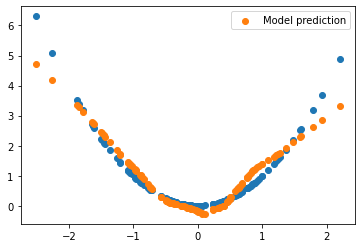

In [13]:
import matplotlib.pyplot as plt

xs = np.random.normal(size=(128, 1))
ys = xs ** 2

for _ in range(1000):
  params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend();

## 自定义 pytree 容器类型

目前为止，我们看到的pytree都是 lists, tuples, 或 dicts，除此之外的都是叶子，如果你定义了一个容器类，也会被JAX当做叶子:

In [16]:
class MyContainer:
  """A named container."""

  def __init__(self, name: str, a: int, b: int, c: int):
    self.name = name
    self.a = a
    self.b = b
    self.c = c

  def __add__(self, other):
    self.a += other

In [17]:
jax.tree_leaves([
    MyContainer('Alice', 1, 2, 3),
    MyContainer('Bob', 4, 5, 6)
])

此时，使用`tree_map`也是针对整个MyContainer对象，因为我们定义了`__add__`，所以是对MyContainer对象+1:

In [19]:
jax.tree_map(lambda x: x + 1, [
    MyContainer('Alice', 1, 2, 3),
    MyContainer('Bob', 4, 5, 6)
])

[None, None]

我们需要在JAX中注册自定义的容器类:

In [20]:
from typing import Tuple, Iterable

def flatten_MyContainer(container) -> Tuple[Iterable[int], str]:
  """Returns an iterable over container contents, and aux data."""
  flat_contents = [container.a, container.b, container.c]

  # we don't want the name to appear as a child, so it is auxiliary data.
  # auxiliary data is usually a description of the structure of a node,
  # e.g., the keys of a dict -- anything that isn't a node's children.
  aux_data = container.name
  return flat_contents, aux_data

def unflatten_MyContainer(
    aux_data: str, flat_contents: Iterable[int]) -> MyContainer:
  """Converts aux data and the flat contents into a MyContainer."""
  return MyContainer(aux_data, *flat_contents)

jax.tree_util.register_pytree_node(
    MyContainer, flatten_MyContainer, unflatten_MyContainer)

jax.tree_leaves([
    MyContainer('Alice', 1, 2, 3),
    MyContainer('Bob', 4, 5, 6)
])

[1, 2, 3, 4, 5, 6]

Modern Python comes equipped with helpful tools to make defining containers easier. Some of these will work with JAX out-of-the-box, but others require more care. For instance:

In [12]:
from typing import NamedTuple, Any

class MyOtherContainer(NamedTuple):
  name: str
  a: Any
  b: Any
  c: Any

# Since `tuple` is already registered with JAX, and NamedTuple is a subclass,
# this will work out-of-the-box:
jax.tree_leaves([
    MyOtherContainer('Alice', 1, 2, 3),
    MyOtherContainer('Bob', 4, 5, 6)
])

['Alice', 1, 2, 3, 'Bob', 4, 5, 6]

Notice that the `name` field now appears as a leaf, as all tuple elements are children. That's the price we pay for not having to register the class the hard way.

## Common pytree gotchas and patterns

### Gotchas
#### Mistaking nodes for leaves
A common problem to look out for is accidentally introducing tree nodes instead of leaves:

In [13]:
a_tree = [jnp.zeros((2, 3)), jnp.zeros((3, 4))]

# Try to make another tree with ones instead of zeros
shapes = jax.tree_map(lambda x: x.shape, a_tree)
jax.tree_map(jnp.ones, shapes)

[(DeviceArray([1., 1.], dtype=float32),
  DeviceArray([1., 1., 1.], dtype=float32)),
 (DeviceArray([1., 1., 1.], dtype=float32),
  DeviceArray([1., 1., 1., 1.], dtype=float32))]

What happened is that the `shape` of an array is a tuple, which is a pytree node, with its elements as leaves. Thus, in the map, instead of calling `jnp.ones` on e.g. `(2, 3)`, it's called on `2` and `3`.

The solution will depend on the specifics, but there are two broadly applicable options:
* rewrite the code to avoid the intermediate `tree_map`.
* convert the tuple into an `np.array` or `jnp.array`, which makes the entire
sequence a leaf.

#### Handling of None
`jax.tree_utils` treats `None` as a node without children, not as a leaf:

In [14]:
jax.tree_leaves([None, None, None])

[]

### Patterns
#### Transposing trees

If you would like to transpose a pytree, i.e. turn a list of trees into a tree of lists, you can do so using `jax.tree_map`:

In [15]:
def tree_transpose(list_of_trees):
  """Convert a list of trees of identical structure into a single tree of lists."""
  return jax.tree_map(lambda *xs: list(xs), *list_of_trees)


# Convert a dataset from row-major to column-major:
episode_steps = [dict(t=1, obs=3), dict(t=2, obs=4)]
tree_transpose(episode_steps)

{'obs': [3, 4], 't': [1, 2]}

For more complicated transposes, JAX provides `jax.tree_transpose`, which is more verbose, but allows you specify the structure of the inner and outer Pytree for more flexibility:

In [16]:
jax.tree_transpose(
  outer_treedef = jax.tree_structure([0 for e in episode_steps]),
  inner_treedef = jax.tree_structure(episode_steps[0]),
  pytree_to_transpose = episode_steps
)

{'obs': [3, 4], 't': [1, 2]}

## More Information

For more information on pytrees in JAX and the operations that are available, see the [Pytrees](https://jax.readthedocs.io/en/latest/pytrees.html) section in the JAX documentation.